# Register and export agar pad movies

Loads ND2 file, does registration and exports data to disk.
This was developed for 2D, multi-channel timelapse data, might need adaptation for 3D or single channel data.

In [1]:
#next two lines make sure that Matplotlib plots are shown properly in Jupyter Notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#next line is required for Napari
%gui qt

#main data analysis packages
import numpy as np

import pandas as pd

#image viewer
import napari

#out of memory computation
import dask.array as da
import dask

#path handling
import pathlib
import nd2

#file handling
import h5py

#image registration
from registration import register_movie

#dask cash
from dask.cache import Cache
cache = Cache(2e9)  # Leverage two gigabytes of memory
cache.register()    # Turn cache on globally

## Load data

In [2]:
#set path to ND2 file
path = pathlib.Path("/Volumes/ScientificData/Users/Giulia(botgiu00)/Collaborations/Ashley/2023-04-05-agar-pad/20230405.nd2")

#set folder where to store output files
process_dir = pathlib.Path('/Volumes/ScientificData/Users/Giulia(botgiu00)/Collaborations/Ashley/2023-04-05-agar-pad-processed/')

In [13]:
!open "smb://unibasel.ads.unibas.ch/BZ/RG van Vliet/ScientificData"


#!mount_smbfs  //vanvli0000@smb:unibasel.ads.unibas.ch/BZ/ /Volumes

In [66]:
f = nd2.ND2File(path)
raw_data = f.to_dask()
#f.close()

In [ ]:
#see metadata https://pypi.org/project/nd2/

In [69]:
f.frame_metadata(0)
f.close()

In [14]:
raw_data
raw_data0 = raw_data[0:5,:2,:,:,:] #select first 5 frames and second position
raw_data0

dask.array<getitem, shape=(5, 2, 3, 2044, 2048), dtype=uint16, chunksize=(1, 1, 3, 2044, 2048), chunktype=numpy.ndarray>

## Visualize with Napari

In [5]:
viewer = napari.view_image(raw_data,
            channel_axis=2,
            name=["phase", "red", "green"],
            colormap=["gray", "red", "green"])
napari.run()

## Register and Export Movie

Warning: this can take a while to run

In [15]:
#reg_data,translation = register_movie(raw_data, process_dir, path.stem, save_to_disk=False)

reg_data = raw_data0

In [20]:
reg_data

dask.array<getitem, shape=(5, 2, 3, 2044, 2048), dtype=uint16, chunksize=(1, 1, 3, 2044, 2048), chunktype=numpy.ndarray>

In [36]:
from skimage.transform import rescale

#@dask.delayed
def rescale_image(image, scale):
    return rescale(image, scale)

In [83]:
import cv2
import ffmpeg

In [87]:
raw_data_Z = raw_data[:,:,np.newaxis,:,:,:]

In [89]:
raw_data_Z

,Array,Chunk
Bytes,108.84 GiB,23.95 MiB
Shape,"(141, 33, 1, 3, 2044, 2048)","(1, 1, 1, 3, 2044, 2048)"
Count,13959 Tasks,4653 Chunks
Type,uint16,numpy.ndarray


In [90]:
# calc average fluor per time point

#get correct z layer and channel
z_layer = 0
channel = 0
fluor_int = raw_data_Z[:,:,z_layer,channel,:,:]

#slice center of y
fluor_int_center = raw_data_Z[:,:,z_layer,channel,300:600,:]



#take mean over all x and y -> array of time X position
mean_fluor = fluor_int.mean(axis=-1).mean(axis=-1)

t0 = 5
dt = 0.5
time = t0 + dt * np.arange(0, mean_fluor.shape[0])

#plot time course for positions
plt.plot(time, mean_fluor[:,0], label="pos 0")
plt.plot(time, mean_fluor[:,1], label="pos 1")
plt.plot(time, mean_fluor[:,2], label="pos 2")




dask.array<mean_agg-aggregate, shape=(141, 33), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>

In [80]:

#this needs to load the whole movie in memory
#min_value_glob = np.quantile(reg_data, 0.05) #min value = 5% percentile
#max_value_glob = np.quantile(reg_data, 0.95)

min_value_glob = 0
max_value_glob = 200

channel = 0 #select channel to show

positions = [0,1]


# open ffmepeg writer
#movie = ffmpeg

# loop over all frames
for frm in range(reg_data.shape[0]):
    frm = 0
    t0 = 4
    dt = 0.5
    #step 1 resize images (write as for loop over positions)

    # select positions and frames and channel

    pos_list = []
    for pos in positions:
        
        pos0 = reg_data[frm,pos,channel,:,:] #select first position

        # if not using @dask.delayed in rescale_image function this will force load into memory and convert to numpy array
        pos_list.append(rescale_image(pos0, 0.5))
        
    #step 2 concatenate images
    im_cat = np.concatenate(pos_list, axis=0)   


    # step 3 brightness correction 

    im_rescaled = im_cat-min_value_glob / (max_value_glob - min_value_glob) #0-1 range

    # step 4 convert to 8 bit
    im_in = np.round(im_rescaled * 255)

    im_in[im_in<0] = 0
    im_in[im_in>255] = 255

    im_int = im_in.astype(np.uint8)

    # convert to RGB grey scale
    im_gray = np.stack((im_int, im_int, im_int), axis=2) #might need be axis = 2

    # convert to RGB green
    im_green = np.stack((np.zeros_like(im_int), im_int, np.zeros_like(im_int)), axis=2) #might need be axis = 2

    # step 5 add text to image

    # Add frame number text:
    # see https://gitlab.com/dunloplab/delta/-/blob/main/delta/pipeline.py around line 900

    time  = t0 + dt * frm

    frame = cv2.putText(
        im_green,
        text=f"frame {frm:06d}",
        org=(0,0),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=5,
        color=(1, 0, 0, 1),
        thickness=2,
    )

    #add current frame with ffmeg to movie
    #movie.write_frame(frame)

#after for loop

#close ffmeg writer 
movie.close()

  

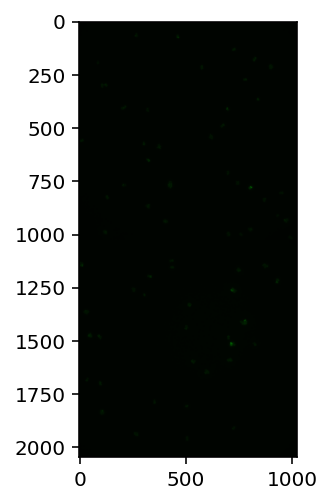

In [81]:
plt.imshow(frame)

## Visualize with Napari

In [47]:
viewer.add_image(reg_data, 
                 channel_axis=2,
                name=["phase1", "red1", "green1"],
                colormap=["gray", "red", "green"])

napari.run()